In [16]:
%matplotlib inline
import logging
import random
import re
import string

import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import pandas as pd

# Data Standardization

Let's use a random dataset in order to put in practice some of the data standardization techniques.

In [2]:
URL_ALBERTA = 'https://open.alberta.ca/dataset/a4b99aad-3f33-45ea-a5c7-e34a4733d336/resource/8e5d4548-fe1a-4f36-a690-3da56af197e6/download/cmhc_preliminary_total_housing_starts_csv_v83.0_2019-08-09.csv'
INTERESTING_COLS = ['Ref_Date', 'Urban Centre', 'Preliminary Housing Starts']

# Read in the DataFrame
df_alberta = pd.read_csv(URL_ALBERTA, usecols=INTERESTING_COLS)

# Fix the 'housing' column so that all rows contain integers
#-- The code for this is outside the scope of the notebook --#
def cast_to_int(val):
    """Takes unclean string representing a number, returns an integer"""
    if val is np.nan:
        return 0
    return int(re.sub('[^\d]', '', val))


df_alberta['Preliminary Housing Starts'] = df_alberta['Preliminary Housing Starts'].apply(cast_to_int)

# Print the dataframe details and first 5 rows
df_alberta.info()
df_alberta.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 3 columns):
Ref_Date                      1359 non-null object
Urban Centre                  1359 non-null object
Preliminary Housing Starts    1359 non-null int64
dtypes: int64(1), object(2)
memory usage: 31.9+ KB


,Ref_Date,Urban Centre,Preliminary Housing Starts
0,07-Jan,Calgary (CMA),800
1,07-Jan,Edmonton (CMA),1145
2,07-Jan,Red Deer (CA),211
3,07-Jan,Lethbridge (CA),71
4,07-Jan,Medicine Hat (CA),59


## Inconsistent Coding
In this example, let's take a look at the values for the `Urban Centre` attribute:

In [3]:
print('The unique values for cities are:', df_alberta['Urban Centre'].unique())

The unique values for cities are: ['Calgary (CMA)' 'Edmonton (CMA)' 'Red Deer (CA)' 'Lethbridge (CA)'
 'Medicine Hat (CA)' 'Wood Buffalo (CA)' 'Grande Prairie (CA)' 'Five CAs'
 'Seven Major Urban Centres' 'Lethbridge (CMA)' 'Four CAs']


Now, *I don't know anything about Alberta urban centres*, so take everything here with a grain of salt.

But let's standardize this so that we have values that "mean something". We'll:
1. Rename the codes so they don't have the `(CMA)` and `(CA)` suffixes
2. Remove the rows for the aggregate values `'Five CAs'`, `'Seven Major Urban Centres'`, and `'Four CAs'`

### Rename codes
Here we use the [pandas string replace method](http://github.com/pandas-dev/pandas/blob/v0.25.0/pandas/core/strings.py#L2709-L2715) to detect the unwanted patterns and replace them with an empty string, `''`.

In [4]:
# Rename Urban Centre suffixes

suffixes = [' (CMA)', ' (CA)']

# Loop through the possible suffix values
for suffix in suffixes:
    # Overwrite the column with the replaced values
    df_alberta['Urban Centre'] = df_alberta['Urban Centre'].str.replace(suffix, '', regex=False)

print('The unique values for cities are:', df_alberta['Urban Centre'].unique())

The unique values for cities are: ['Calgary' 'Edmonton' 'Red Deer' 'Lethbridge' 'Medicine Hat'
 'Wood Buffalo' 'Grande Prairie' 'Five CAs' 'Seven Major Urban Centres'
 'Four CAs']


In [5]:
# Remove the aggregate rows

aggregate_values = ['Five CAs', 'Seven Major Urban Centres', 'Four CAs']

# Overwrite the DataFrame only with the rows not in the aggregate rwos
df_alberta = df_alberta[~df_alberta['Urban Centre'].isin(aggregate_values)]  # Tilde negates the query
print('The unique values for cities are:', df_alberta['Urban Centre'].unique())

The unique values for cities are: ['Calgary' 'Edmonton' 'Red Deer' 'Lethbridge' 'Medicine Hat'
 'Wood Buffalo' 'Grande Prairie']


Now let's take a look at the first few entries again!

In [6]:
df_alberta.head()

,Ref_Date,Urban Centre,Preliminary Housing Starts
0,07-Jan,Calgary,800
1,07-Jan,Edmonton,1145
2,07-Jan,Red Deer,211
3,07-Jan,Lethbridge,71
4,07-Jan,Medicine Hat,59


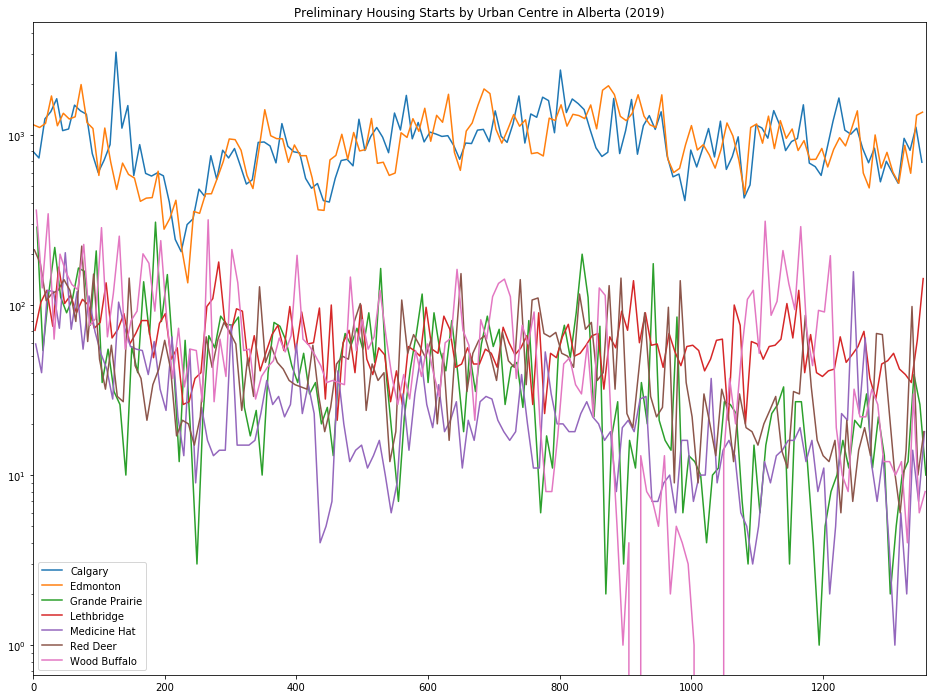

In [20]:
group_by_city = df_alberta.groupby('Urban Centre')['Preliminary Housing Starts']
group_by_city.plot(
                   logy=True,
                   legend=True,
                   figsize=(16, 12),
                   title='Preliminary Housing Starts by Urban Centre in Alberta (2019)'
                  )
plt.show()

Much better!

## Invalid Values

Here we'll use a mock dataset in order to illustrate some points.

For the sake of argument, let's imagine that in our use case, invalid values that go through our data processinng pipeline will break downstream applications &mdash; say, a dashboard that's refreshed every time new data comes in.

In [8]:
invalid_data = {
    'group': ['A', 'A', 'B', 'B', 'Z', 'A', 'B', 'A', 'B'],
    'location': ['Ottawa', 'Montréal', 'Ottawa', 'Red Deer', 'Ottawa', 'unknown', 'Toronto', 'Ottawa', 'Vancouver'],
    'sales': [int(100 * random.random()) for i in range(1, 10)]
}
df_invalid = pd.DataFrame.from_dict(invalid_data)
df_invalid

,group,location,sales
0,A,Ottawa,65
1,A,Montréal,54
2,B,Ottawa,52
3,B,Red Deer,72
4,Z,Ottawa,94
5,A,unknown,11
6,B,Toronto,96
7,A,Ottawa,14
8,B,Vancouver,80


Let's assume here that the values `Z` for the group and `unknown` for the location are invalid.

There are two ways to handle this:
1. A list of valid values (whitelist)
2. A list of invalid values (blacklist)

And there are two notable ways of handling them:
1. We log the error but keep the pipeline going, using some fallback value
2. We error out the pipeline, and wait for human intervention to fix the offending data

All permutations of these have valid use cases, and depend on the situation.

### Strategy \#1: Whitelist and error out
This strategy is good standard practice, but assumes there are (timely) processes in place to correct the data at the source.

In [9]:
VALID_GROUPS = ['A', 'B']
INVALID_GROUP_ERROR = 'Some invalid values were detected for column "group". Aborting pipeline.'

# Whitelist the group values, error out if invalid value is detected
assert all(df_invalid['group'].isin(VALID_GROUPS)), INVALID_GROUP_ERROR

AssertionError: Some invalid values were detected for column "group". Aborting pipeline.

### Strategy \#2: Blacklist and log occurences
We can also simply log the invalid data and use a fallback value instead. In this case, we can simply log the occurence.

In [10]:
# Create a logging object, which we'll use to monitor our data pipeline
logger = logging.Logger('Mock Data Pipeline')

INVALID_LOCATIONS = ['unknown', 'NA', 'N/A', ' ', '']


def check_valid_locations(data, invalid=INVALID_LOCATIONS):
    """Given a Series of location values, replaces known invalid values
    and logs the errors"""
    values = []
    for ix, value in enumerate(data):
        if value in invalid:
            logger.warning(f'Invalid location value at index {ix}: "{value}". Replacing with missing value.')
            value = np.nan
        values.append(value)
    return values
        

df_invalid['clean_location'] = check_valid_locations(df_invalid['location'])
df_invalid

Invalid location value at index 5: "unknown". Replacing with missing value.


,group,location,sales,clean_location
0,A,Ottawa,65,Ottawa
1,A,Montréal,54,Montréal
2,B,Ottawa,52,Ottawa
3,B,Red Deer,72,Red Deer
4,Z,Ottawa,94,Ottawa
5,A,unknown,11,NaN
6,B,Toronto,96,Toronto
7,A,Ottawa,14,Ottawa
8,B,Vancouver,80,Vancouver


## Numeric Values
For the following sections, we'll use a real-world example. Each row represents a house in California sold on the market, with each attribute representing either characteristics of the neighbourhood, or the house itself.

In [11]:
# Get dataset
URL = 'https://github.com/spiderPan/Google-Machine-Learning-Crash-Course/raw/master/data/california_housing_train.csv'
df_housing = pd.read_csv(URL)
df_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


Let's focus on a few attributes:

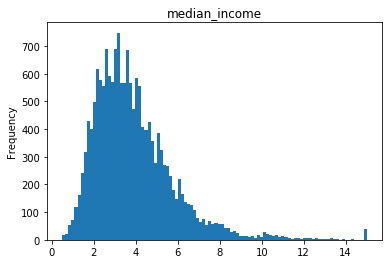

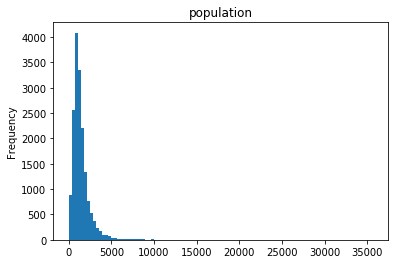

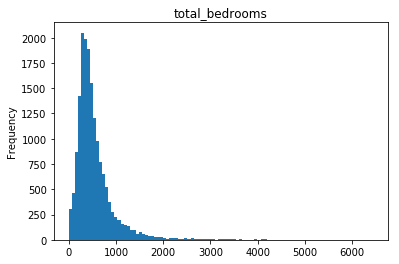

In [12]:
interesting_cols = ['median_income', 'population', 'total_bedrooms']

for col in interesting_cols:
    df_housing[col].plot(kind='hist', title=col, bins=100)
    plt.show()

## Numeric Values &mdash; Normalization

$$x_{new} = \frac{x-x_{min}}{x_{max} - x_{min}}$$

In this example we use scikit-learn's `preprocessing.normalize` method to perform the normalization, but it would be just as easy to do this with vanilla numpy methods.

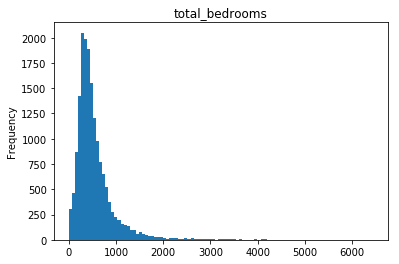

Max value: 6445.0
Min value: 1.0
Mean value: 539.41


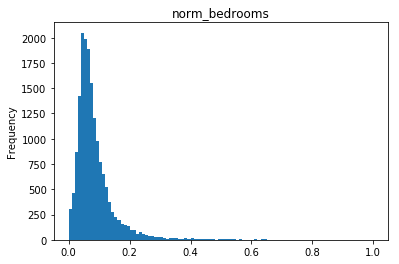

Max value: 1.0
Min value: 0.0
Mean value: 0.08


In [13]:
# Normalize total_bedrooms column
x_array = df_housing['total_bedrooms'].values
norm = preprocessing.normalize([x_array], norm='max')

# Add as new column to our DataFrame
df_housing['norm_bedrooms'] = norm.T  # Flip the vector by transposing

# Plot with with original
for col in ['total_bedrooms', 'norm_bedrooms']:
    df_housing[col].plot(kind='hist', title=col, bins=100)
    plt.show()
    print(f"Max value: {round(df_housing[col].max(), 2)}")
    print(f"Min value: {round(df_housing[col].min(), 2)}")
    print(f"Mean value: {round(df_housing[col].mean(), 2)}")

So we see the shape of the distribution is exactly the same, but the scale of the values is now constrained within $[0, 1]$.

## Numeric Values &mdash; Standardization

$$x_{new} = \frac{x-\mu}{\sigma}$$

Here, we'll simply use the DataFrame methods `.mean` and `.std` to calculate a new column to our DataFrame.

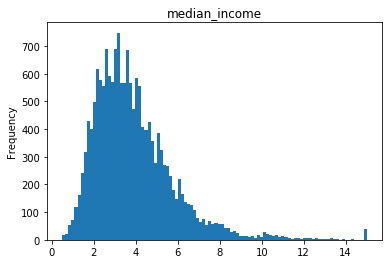

Max value: 15.0
Min value: 0.5
Mean value: 3.88


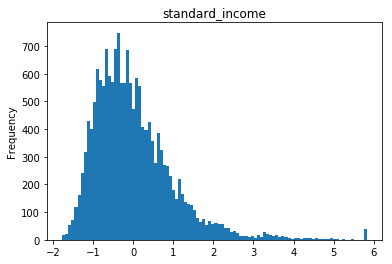

Max value: 5.83
Min value: -1.77
Mean value: -0.0


In [14]:
# Fit your data on the scaler object
median_income_mean = df_housing['median_income'].mean()
median_income_std = df_housing['median_income'].std()

df_housing['standard_income'] = (df_housing['median_income'] - median_income_mean) / median_income_std

for col in ['median_income', 'standard_income']:
    df_housing[col].plot(kind='hist', title=col, bins=100)
    plt.show()
    print(f"Max value: {round(df_housing[col].max(), 2)}")
    print(f"Min value: {round(df_housing[col].min(), 2)}")
    print(f"Mean value: {round(df_housing[col].mean(), 2)}")

Again, the shape of the distribution is exactly the same, but this time the mean of the distribution is at zero, and the unit value is equal to one standard deviation away from the mean.

## Numeric Values &mdash; Outliers

### Z-Score
This method uses the same function as for standardization, but uses the Z-score number as a threshold value that determines whether we keep that value or not. In this case, we decide to remove any value that is farther than 5 standard deviations away from the average.

Expert knowledge of the domain is sometimes required in order to set the threshold value.

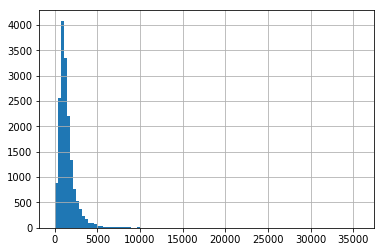

Max value: 35682.0
Min value: 3.0
Mean value: 1429.57


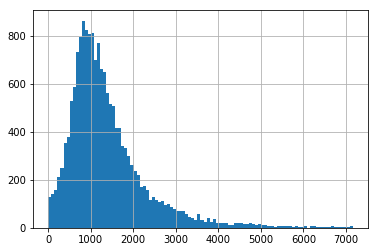

Max value: 7158.0
Min value: 3.0
Mean value: 1386.0


In [21]:
def is_outlier(x, threshold=5.0):
    """
    Returns true if the value exceeds the threshold from distribution mean.
    
    Default: 5 standard deviations.
    """
    return ((x - x.mean()) / x.std()).abs() < threshold


# Plot the original
df_housing['population'].hist(bins=100)
plt.show()
print(f"Max value: {round(df_housing['population'].max(), 2)}")
print(f"Min value: {round(df_housing['population'].min(), 2)}")
print(f"Mean value: {round(df_housing['population'].mean(), 2)}")

# Plot the cleaned version
cleaned = df_housing[df_housing['population'].transform(lambda x: is_outlier(x))]['population']
cleaned.hist(bins=100)
plt.show()
print(f"Max value: {round(cleaned.max(), 2)}")
print(f"Min value: {round(cleaned.min(), 2)}")
print(f"Mean value: {round(cleaned.mean(), 2)}")